In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
    CompoundNormSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
path_public_pks = "../PKS_flare/HESS_public/"
sys_percentage = np.array([10] * 24)

In [4]:
pksflare_dataset = MapDataset.read(path_public_pks+"dataset-stacked.fits.gz")
pksflare_dataset_sys = pksflare_dataset.copy()
regions = "icrs;circle( 329.717, -30.225, 0.4)"
mask_map = pksflare_dataset.counts.geom.region_mask(regions, inside = False)

pksflare_dataset_sys.mask_safe = mask_map
pksflare_dataset.mask_safe = mask_map

emask = pksflare_dataset.mask.data.sum(axis=2).sum(axis=1)>0
energy = pksflare_dataset.geoms['geom'].axes[0].center[emask]

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    reference             (frozen):      1.000       TeV         




/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

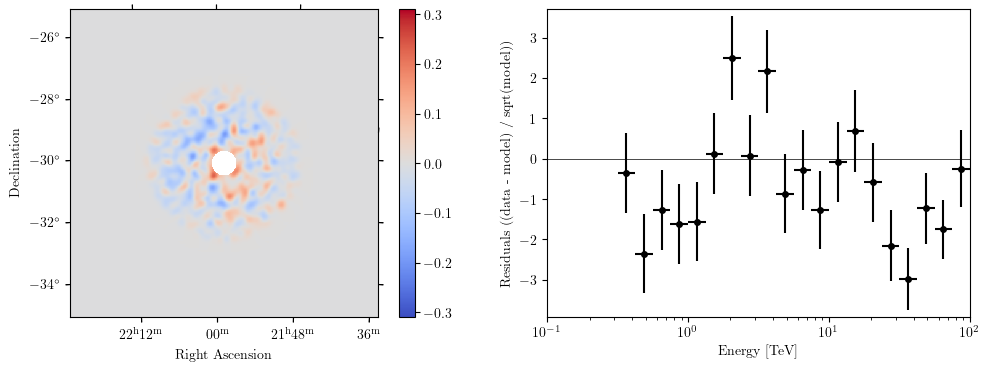

In [5]:

bkg = FoVBackgroundModel(dataset_name=pksflare_dataset.name)
bkg.parameters['tilt'].frozen = False

pksflare_dataset.models = Models([ bkg])
print(pksflare_dataset.models)


pksflare_dataset.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [6]:
%%time
fit = Fit()
fit.run(pksflare_dataset)

CPU times: user 2.23 s, sys: 972 ms, total: 3.21 s
Wall time: 3.21 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : 205309.89

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [7]:
print(pksflare_dataset.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      0.986   +/-    0.01             
    tilt                          :     -0.003   +/-    0.01             
    reference             (frozen):      1.000       TeV         




(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

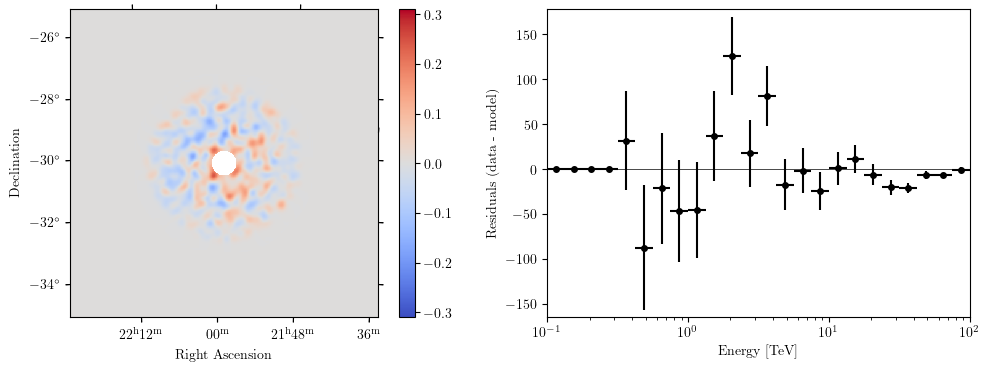

In [8]:
pksflare_dataset.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff'})

In [9]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            #try:
            plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            #except:
            #    pass

    plt.tight_layout()
    return fig

labels = [ 'fitted', 'fitted with BKG sys']
fmts = ['o','x', '*']
markersize = [6,10, 10]

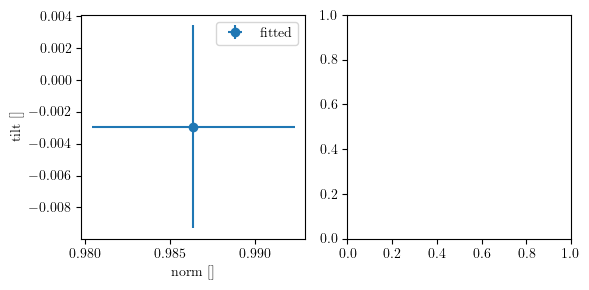

In [10]:
models_list = [ pksflare_dataset.models, ]
colors = ['tab:blue', 'tab:orange', 'tab:green']
pars =  pars = [('norm', 'tilt'),]
fig = plot_source_par(0, pars)


## BKG Energybin wise systematic

In [11]:
l = len(energy)
norms = Parameters([Parameter ("norm"+str(i), value = 0, is_penalised = True, 
                               frozen = True) for i in range(len(energy))])
for i in range(len(norms)):
    if sys_percentage[i] > 0:
        norms[i].frozen = False
piece = PiecewiseNormSpectralModel(energy = energy,
                          norms = norms)

import operator
bkg_spectral = CompoundNormSpectralModel(model1 = piece, 
                                        model2 = PowerLawNormSpectralModel(),
                                        operator= operator.add)

bkg_sys = FoVBackgroundModel(spectral_model = bkg_spectral,
                            dataset_name= pksflare_dataset_sys.name)
bkg_sys.parameters['tilt'].frozen = False
pksflare_dataset_sys.models = Models([bkg_sys])

0.10000000000100001


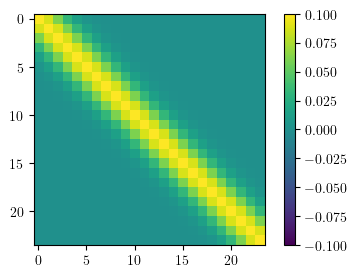

In [12]:
from scipy.stats import norm
l = len(energy) 
cov = np.ones((l,l)) * 1e-12
cov = np.identity(l)

# note: values set arbitrarily 
for i in range(l):
    if sys_percentage[emask][i] > 0:
        gau = norm.pdf(range(l) , loc = i , scale = 2 )
        cov[i,:] = gau / np.max(gau) * sys_percentage[emask][i] / 100 
        cov[i,:] += [1e-12] * (l)
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(cov, vmin = 0, vmax = 0.0)
fig.colorbar(pos, ax=ax1)
print(cov.max())

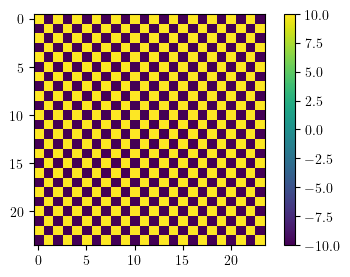

In [13]:
from numpy.linalg import inv
ainv = inv(cov)
pksflare_dataset_sys.penalising_invcovmatrix = ainv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(ainv, vmin = -10, vmax = 10)
fig.colorbar(pos, ax=ax1)

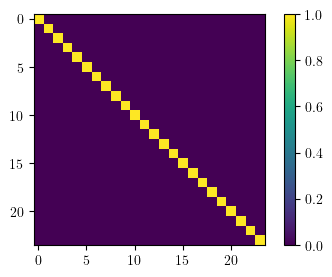

In [14]:
from numpy.linalg import inv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(np.matmul(cov,ainv), vmin = 0, vmax = 1)
fig.colorbar(pos, ax=ax1)

In [15]:
%%time
fit_sys = Fit()
fit_sys.run(pksflare_dataset_sys)

CPU times: user 5min 29s, sys: 2min 22s, total: 7min 52s
Wall time: 7min 52s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization failed.
	nfev       : 5232
	total stat : 205283.93

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

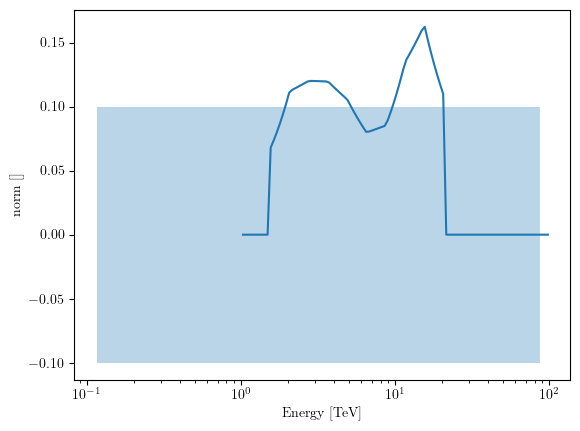

In [16]:
pksflare_dataset_sys.models[0].spectral_model.model1.plot([1,100]*u.TeV)
plt.fill_between(energy.value, sys_percentage[emask]/100,-sys_percentage[emask]/100,
                alpha = 0.3)

plt.yscale("linear")

In [17]:
print(pksflare_dataset_sys.models[0])

FoVBackgroundModel

  Name                      : McNgmWRP-bkg
  Datasets names            : ['McNgmWRP']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm0                         :     -0.014   +/-    0.10             
    norm1                         :     -0.021   +/-    0.04             
    norm2                         :     -0.022   +/-    0.02             
    norm3                         :     -0.016   +/-    0.01             
    norm4                         :     -0.014   +/-    0.01             
    norm5                         :     -0.032   +/-    0.01             
    norm6                         :     -0.064   +/-    0.00             
    norm7                         :     -0.068   +/-    0.00             
    norm8                         :     -0.012   +/-    0.00             
    norm9                         :      0.067   +/-    0.00             
    norm10                        :      0.112   +/- 

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

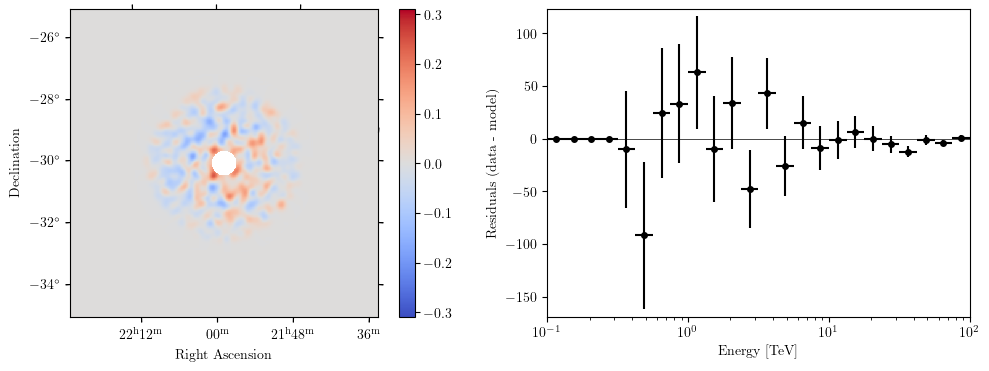

In [18]:

pksflare_dataset_sys.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff'})

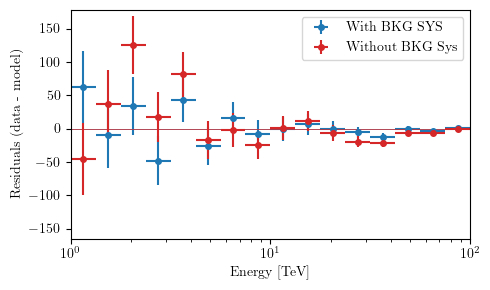

In [19]:
fig, ax = plt.subplots(figsize = (5,3))
ax = pksflare_dataset_sys.plot_residuals_spectral(method =  'diff', color = 'tab:blue',
                                             label = "With BKG SYS")
pksflare_dataset.plot_residuals_spectral(method =  'diff', color = 'tab:red', ax = ax,
                                    label = "Without BKG Sys")
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(1,100)
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1_spectracl_res_points_diff.png')

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1160: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


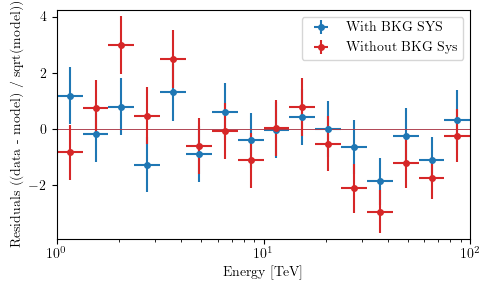

In [20]:
fig, ax = plt.subplots(figsize = (5,3))
ax = pksflare_dataset_sys.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:blue',
                                             label = "With BKG SYS")
pksflare_dataset.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:red', ax = ax,
                                    label = "Without BKG Sys")
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(1,100)
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1_spectracl_res_points.png')

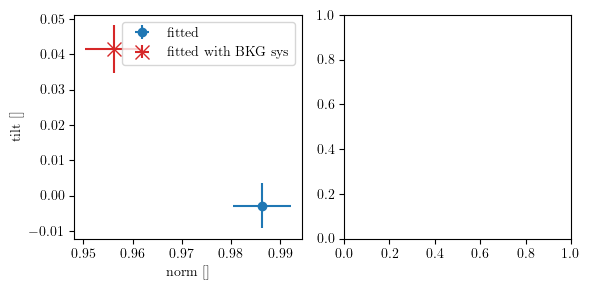

In [21]:
models_list = [ pksflare_dataset.models, pksflare_dataset_sys.models ]
colors = ['tab:blue', 'tab:red', 'tab:green']
pars =  pars = [('norm', 'tilt')]
ax = plot_source_par(0, pars)


## LimaSign

In [22]:
from gammapy.estimators import ExcessMapEstimator
from scipy.stats import norm


def com_excl_mask_2d(dataset):
    
    excl_regions = []
    box_center = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    box = RectangleSkyRegion(center=box_center, width=4*u.deg, height=1.6*u.deg)
    #source_303 = CircleSkyRegion(center=cat['HESS J1745-303'].position, radius=1.2*u.deg)#was0.9
    source_303 = CircleSkyRegion(center=SkyCoord(358.71, -0.64, unit='deg', frame='galactic'), radius=0.9*u.deg)
    excl_regions = [box, source_303]
    geom= dataset.geoms["geom"]
    geom_2d = geom.slice_by_idx(dict(energy=1))
    excl_mask_2d = Map.from_geom(geom_2d, data=geom_2d.region_mask(excl_regions, inside=False).data)
    return excl_mask_2d


def compute_lima(dataset, edges):
        
    thr = 0.1
    estimator = ExcessMapEstimator(
        correlation_radius=corr_radius,
        selection_optional='all',
        energy_edges=edges,
    ) #was 0.1
    result = estimator.run(dataset)
    
    return result
    
def lima1a (dataset, result, title = None):

    if len(result["sqrt_ts"].geom.axes[0].center) ==1: 
        result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-{title}.pdf")
            fig.savefig(f"plots/9a-lima-{title}.svg")
    else:
        
        result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title+ f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-e-{title}.pdf")
            fig.savefig(f"plots/9a-lima-e-{title}.svg")
            
    return fig


    
def lima1b(result, title):    
    
    
    significance_data = result["sqrt_ts"].data
    
    print(result["sqrt_ts"].data.shape[0])


    selection = np.isfinite(significance_data) & (np.abs(significance_data) > 5e-3)
    significance_data = significance_data[selection]

    plt.hist(significance_data, density=True, alpha=0.9, color="firebrick", bins=40)
    mu, std = norm.fit(significance_data)

    x = np.linspace(-5, 5, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x,p,lw=2,color="black",
             label=r"$\mu$ = {:.6f}, $\sigma$ = {:.6f}".format(mu, std),)
    
    
    p = norm.pdf(x, 0, 1)

    plt.plot(x,p,lw=2,color="tab:blue",
             label=r"$\mu$ = {:.3f}, $\sigma$ = {:.3f}".format(0, 1),)
    plt.legend(fontsize=14)
    plt.xlim(-5.5, 5.5)
    ax =plt.gca()
    plt.ylim(1e-4, ax.get_ylim()[1]) 
    plt.yscale('log')
    fig = plt.gcf()
    if title is not None:
        st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
        #fig.tight_layout()
        
        st.set_y(0.99)
        fig.subplots_adjust(top=0.85)
        fig.savefig(f"plots/9a-lima-dist-{title}.pdf")
        fig.savefig(f"plots/9a-lima-dist-{title}.svg")
        
    
    #pic=pic+1;plt.savefig(f'../tempo/{key}_{pic}.pdf');
    #plt.close() # res dist _6

    
   

In [23]:
corr_radius = 0.1* u.deg
thr = 1
titles = ["With BKG sys", "with out"]

In [24]:
%%time
computing = 1
if computing:
    edges = [thr, 100] * u.TeV
    result_impact = compute_lima (pksflare_dataset_sys,edges)
    result_impact.write(f'data/1_lima_sys_{corr_radius}_deg_bkg_only.fits',overwrite = True)    
else:
    from gammapy.estimators.map import FluxMaps
    result_impact= FluxMaps.read(f'data/1_lima_sys_{corr_radius}_deg_bkg_only.fits')

Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.72244675, -30.22026042)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 7min 24s, sys: 154 ms, total: 7min 24s
Wall time: 7min 26s


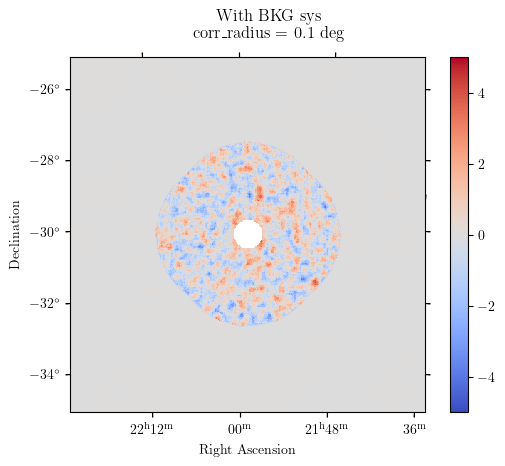

In [25]:
fig = lima1a(pksflare_dataset_sys, result_impact, titles[0])

1


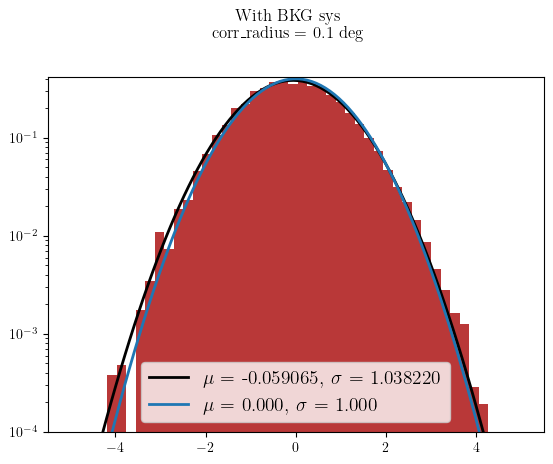

In [26]:
fig = lima1b( result_impact, titles[0])

### without

In [27]:
%%time
computing = 1
if computing:
    edges = [thr, 100] * u.TeV
    result_crab = compute_lima (pksflare_dataset,edges)
    result_crab.write(f'data/1_lima_{corr_radius}_deg_bkg_only.fits', overwrite = True)    
else:
    result_crab = FluxMaps.read(f'data/1_lima_{corr_radius}_deg_bkg_only.fits')    
    

Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.72244675, -30.22026042)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 7min 20s, sys: 134 ms, total: 7min 20s
Wall time: 7min 22s


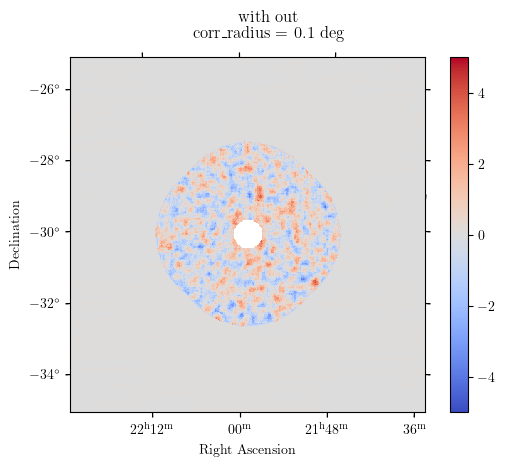

In [28]:
fig = lima1a(pksflare_dataset, result_crab, titles[1])

1


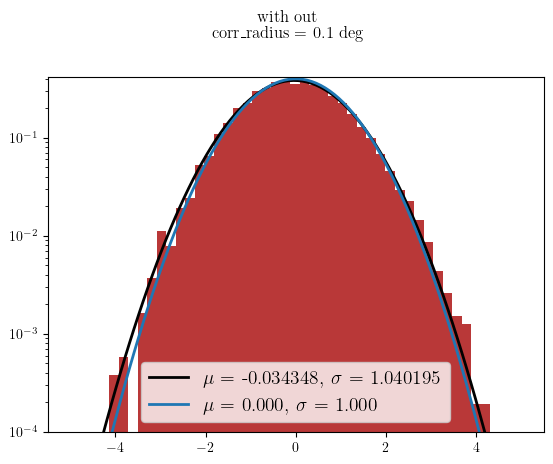

In [29]:
fig = lima1b( result_crab, titles[1])